In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import sentencepiece as spm

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in raw shakespeare text
text = open('tiny-shakespeare.txt','r').read()

vocab_size = 256

# Get tokens (BPE)
spm.SentencePieceTrainer.train(input='tiny-shakespeare.txt', vocab_size=vocab_size, model_type='bpe', model_prefix='mb', user_defined_symbols='\n')

# Language Model (BPE)
spb = spm.SentencePieceProcessor('mb.model')

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: tiny-shakespeare.txt
  input_format: 
  model_prefix: mb
  model_type: BPE
  vocab_size: 256
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: 

  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 0
  dif

In [83]:
class Shakepeare(Dataset):
    def __init__(self, text, block_size) -> None:
        super().__init__()
        self.text = text
        self.block_size = block_size
    
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        #ix = torch.randint(self.randlen
        index = min(index, len(self.text) - self.block_size - 1)
        x = self.text[index:index+self.block_size]
        y = self.text[index + 1:index+self.block_size + 1]
        return x, y

block_size = 32
batch_size = 128
data = Shakepeare(torch.tensor(spb.Encode(text)), block_size=block_size)

print (len(data))
data_dl = DataLoader(data, batch_size=batch_size, shuffle=True)

count = 0
for batch in data_dl:
    count += 1
    
    x, y = batch 
    print (x)
    print (y)
    print ()
    dx = spb.Decode(x.tolist())
    dy = spb.Decode(y.tolist())

    for wx, wy in zip(dx, dy):
        print (f'x ={wx:>25s} // y = {wy:>25s}')
    break
    

619797
tensor([[ 20, 145,  54,  ...,  52, 204,  50],
        [  3, 230, 228,  ..., 198, 221,   3],
        [ 15,  38,  67,  ..., 215, 209,  56],
        ...,
        [ 99,  12,  65,  ...,   3, 222, 218],
        [  9, 129,   3,  ..., 186, 206,  79],
        [ 74,  17, 126,  ..., 140, 169,  44]])
tensor([[145,  54, 216,  ..., 204,  50, 199],
        [230, 228, 238,  ..., 221,   3,   3],
        [ 38,  67,  94,  ..., 209,  56, 221],
        ...,
        [ 12,  65, 203,  ..., 222, 218,   7],
        [129,   3, 225,  ..., 206,  79, 218],
        [ 17, 126, 210,  ..., 169,  44, 212]])

x =I do beg his life, if it be sin,
Heaven let me bear it! you gran // y = do beg his life, if it be sin,
Heaven let me bear it! you grant
x =
ROMEO:
Do so, and bid my sweet prepare to chide.
 // y = ROMEO:
Do so, and bid my sweet prepare to chide.


x =nd put your trial in the villain's mouth
Which here you come to accuse // y = put your trial in the villain's mouth
Which here you come to accuse.
x =ea
Force

In [84]:
device = "mps"
n_embd = 64

class RNN(nn.Module):
    def __init__(self, vocab_size, n_embd) -> None:
        super().__init__()

        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.lm_out = nn.LazyLinear(vocab_size)

    def forward(self, x):
        x = self.token_embedding(x)
        x = self.lm_out(x)

        return x




# Test Model
model = RNN(vocab_size, n_embd)

i = 0
for batch in data_dl:
    x, y = batch
    print (x[0], model(x).shape, y.shape)
    i += 1

    if i > 5:
        break

tensor([209, 198,  31,  46,  20, 183, 126, 223, 184, 203, 220,  29,  65,  52,
        200, 127, 234,   3, 225,   5,  49, 214,  31, 215,  30,  85, 113,   9,
         95, 198,  37, 145]) torch.Size([128, 32, 256]) torch.Size([128, 32])
tensor([207, 219, 202, 121, 196,  16, 200, 207, 199,   3, 231, 219, 207,  23,
        226,  43,  14,  82, 205, 213,  66, 216, 146, 218,  61,  46,  52, 205,
         33,  61, 208,  35]) torch.Size([128, 32, 256]) torch.Size([128, 32])
tensor([214,   3, 228, 214, 158,  14,  10,  18,  63,  20, 169,  44, 208,  46,
         36, 114,  38,  67,   3, 225,   5,   9,  50, 201, 157,  49,  57,  99,
         53, 198, 234, 125]) torch.Size([128, 32, 256]) torch.Size([128, 32])
tensor([207,  31,  75,  19, 188, 120,  36,  76, 212,   3, 222, 203,  26, 201,
        209,  56,  25,  45, 202,   9,  11,  17, 171, 221, 105, 200,  26, 201,
         22,   6, 199, 104]) torch.Size([128, 32, 256]) torch.Size([128, 32])
tensor([165, 198,   8, 202,  96, 214, 199, 221,  84, 102, 212,  

(torch.Size([128, 32, 256]), torch.Size([128, 32]))

In [179]:
device = "mps"
one_step = False
train_lr = True

# Model
model = RNN(vocab_size, n_embd).to(device)

loss_fn = nn.CrossEntropyLoss()
LR = torch.logspace(-5,0, len(data_dl))

losses = []

optimizer = torch.optim.SGD(model.parameters(), lr=0.25)

for epoch in range(2):
    for step, batch in enumerate(data_dl):
        x, y = batch
        x, y = x.to(device), y.to(device)

        #print (x[0], y[0])

        logits = model(x)

        loss = loss_fn(logits.view(-1, vocab_size), y.view(-1)) 
 
        losses.append(loss.item())

        if train_lr:
            optimizer = torch.optim.SGD(model.parameters(), lr=LR[step])
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if one_step:
            break
    
    print (epoch, loss.item())

    if one_step or train_lr:
        break



model = model.to("cpu")
model.eval()
x, y = next(iter(data_dl))
#x = x.t

#idx = x[0].view(1,-1)
idx = torch.zeros((1, 1), dtype=torch.long)#.to(device)
for _ in range(500):

    idx_cond = idx[:, -block_size:]
    logits = model(idx_cond)
    
    logits = logits[:, -1, :]

    probs = F.softmax(logits, dim=-1)

    idx_next = torch.multinomial(probs, num_samples=1)
    idx = torch.cat((idx, idx_next), dim=1)


print (spb.Decode(idx.tolist())[0])

0 4.027409076690674
 ⁇ c, rale a pre's
Thengood!ight:
M en not onherese me king one mong:
U dis some, g pro sok.
Fir are forlouraster, l weend commek her:
Ler ofesverCtly:
Whi thisgh my te that I s not onledra tecy not be?
W the a C,ood, to Me and youher
Th,


WhichNThat fy daper pher
R,way comeght:
R.
A M heon,verNGroa a catege hords
We in RBRO heall artosere to see is, and, ind of herond make, Mer of this, ' must inp fra my pock aou sous
As ofruhat'de lo may iset himER will whathould itterauchy pa S o Banen cJIsone his:

AN qurener, jod tosar ' that.
And with eUCHORFain Thatters a comr lo my murpainRe theay,per usqustill,,
ekec de.
But me,
Wy swn Gake thee.
INIArestorppost thegend,
B carefce doj thee,
A to gickhat d ro thatterly ex.orsefi'll thd, witurp w That YsNNo nown bet,
Miure t,
DUK proome,- the bothy, their, do En.
CHgenakghtp killES howavercess eeak,:id not areUKs the Yestercuty ntet Kp:
Th baceQ


Best learning rate is: tensor([0.1036])


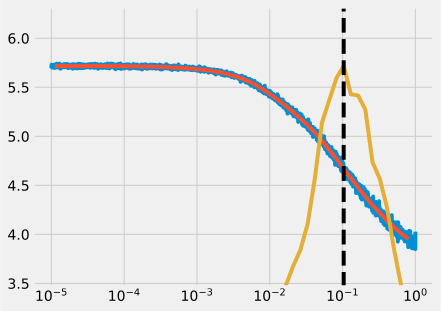

In [183]:
losses = torch.tensor(losses)
M = len(losses)//50
N = len(LR) - len(LR)%M
mLR = LR[:N].view(-1,M).mean(dim=1)
mlosses = losses[:N].view(-1,M).mean(dim=1)

plt.semilogx(LR, losses)
plt.semilogx(mLR, mlosses)
gradd = -torch.gradient(mlosses)[0]

plt.semilogx(mLR, gradd/gradd.max()*mlosses.max())
plt.ylim(0.9*losses.min(), 1.1*losses.max())
xx = mLR[gradd == gradd.max()]
plt.plot([xx, xx], [0.9*losses.min(), 1.1*losses.max()],'k--')
print (f'Best learning rate is: {xx}')


In [173]:
len(losses)//50

96